# Assignment 2: Signals on model fairness from data and model

This assignment is broken down in two parts. In the first part of the assignment, we will walk through ProPublica's analysis of the COMPAS tool and observe how the underlying data indicates potential issues of differences in predictions. In the second part of the assignment, we will explore fairness while a model is trained on the data.

## Part 1: ProPublica's analysis of the COMPAS tool

We discussed the COMPAS case in class following ProPublica's published [article](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing). COMPAS is a proprietary tool which generates a so-called risk assessment for defendants in a criminal trial. ProPublica's analysis focused on the "recidivism score," which purports to provide the likelihood of recidivism (i.e. committing a misdemeanor of felony) within two years of assessment.

In this assignment, we will go through parts of ProPublica's analysis of COMPAS, focusing on how the recidivism risk scale varies by race and sex.

This notebook has four stages in which we will:
1. Import the data, implement a few pre-processing steps, and inspect the data
2. Run a short exploratory analysis of the COMPAS recidivism score, our primary variable of interest
3. Reproduce the logistic regression model in ProPublica's analysis and interpret the estimates
4. Compute the predictive accuracy of the risk score labels

### Packages and Modules

You may need to install the following packages:




In [2]:
# %pip install pandas numpy statsmodels matplotlib seaborn

Import the packages and modules:


In [3]:
import math
import random
random.seed(6)

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sys
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

### 1.1. Load Data

Import the data from ProPublica's compas-analysis repository on GitHub and check the first few rows:

In [4]:
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df_compas = pd.read_csv(url)
print("Shape: ", df_compas.shape)
df_compas.head(5)

Shape:  (7214, 53)


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


### Notes on the Data

Refer to the description of the [data collection methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm). Salient points are highlighted below; see the full description from ProPublica for additional details.

> **Goal:** We looked at more than 10,000 criminal defendants in Broward County, Florida, and compared their predicted recidivism rates with the rate that actually occurred over a two-year period.
>
> **COMPAS tool input (data subjects):** When most defendants are booked in jail, they respond to a COMPAS questionnaire. Their answers are fed into the COMPAS software to generate several scores including predictions of Risk of Recidivism and Risk of Violent Recidivism.
>
> **How COMPAS input was acquired by ProPublica:** Through a public records request, ProPublica obtained two years worth of COMPAS scores from the Broward County Sheriff’s Office in Florida. We received data for all 18,610 people who were scored in 2013 and 2014.
>
> **COMPAS tool output:** Each pretrial defendant received at least three COMPAS scores: "Risk of Recidivism," "Risk of Violence" and "Risk of Failure to Appear. [...] COMPAS scores for each defendant ranged from 1 to 10, with ten being the highest risk. Scores 1 to 4 were labeled by COMPAS as "Low;" 5 to 7 were labeled “Medium;" and 8 to 10 were labeled “High.”
>
> **Data integration (record linkage):** Starting with the database of COMPAS scores, we built a profile of each person’s criminal history, both before and after they were scored. We collected public criminal records from the Broward County Clerk’s Office website through April 1, 2016. On average, defendants in our dataset were not incarcerated for 622.87 days (sd: 329.19). We matched the criminal records to the COMPAS records using a person’s first and last names and date of birth. This is the same technique used in the Broward County COMPAS validation study conducted by researchers at Florida State University in 2010. We downloaded around 80,000 criminal records from the Broward County Clerk’s Office website.
>
> **What is recidivism?** Northpointe defined recidivism as “a finger-printable arrest involving a charge and a filing for any uniform crime reporting (UCR) code.” We interpreted that to mean a criminal offense that resulted in a jail booking and took place after the crime for which the person was COMPAS scored. For most of our analysis, we defined recidivism as a new arrest within two years.

### 1.2. Inspect Data

For convenience, here is a table of variable definitions:

| Variable    | Description |
| ----------- | ----------- |
| age       |  Age of the defendant   |
| age_cat   |  Age category. It can be < 25, 25-45, >45    |
| sex   |  Sex of the defendant. It is either "Male" or "Female"       |
| race   |  Race of the defendant. It can be "African-American", "Caucasian", "Hispanic", "Asian", or "Other"      |
| c_charge_degree   |   Charge. Either "M" for misdemeanor, "F" for felony, or "O" (not causing jail time)    |
| priors_count   |   Count of prior crimes committed by the defendant      |
| days_b_screening_arrest   |  Days between the arrest and COMPAS screening       |
| decile_score   |  The COMPAS score estimated by the system. It is between 0-10       |
| score_text   |  Decile score. It can be "Low" (1-4), "Medium" (5-7), or "High" (8-10)       |
| is_recid   |  Indicates if the defendant recidivated. It can be 0, 1, or -1      |
| two_year_recid   |  Indicates if the defendant recidivated within two years of COMPAS assessment      |
| c_jail_in   |   Date the defendant was in jail      |
| c_jail_out  |   Date when the defendant was released from jail     |


~~**TODO:** Plot the distribution of age, race, and sex in the imported data (```df_compas```):~~

d:\Anaconda\envs\MDL2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\envs\MDL2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\envs\MDL2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


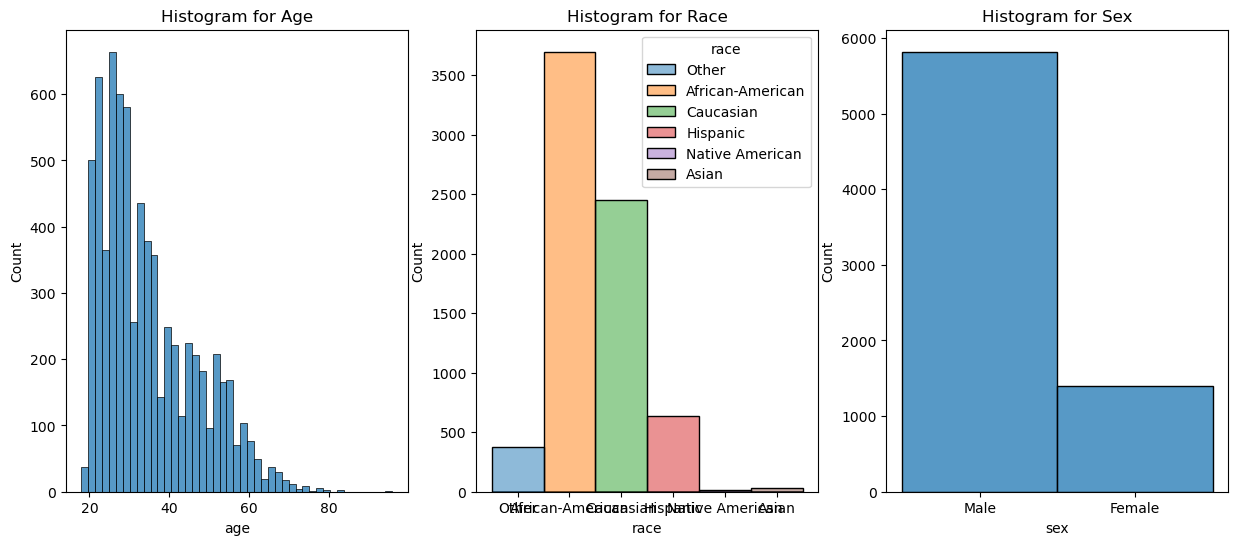

In [5]:
# write code to plot the distribution of age, race, and sex
# in this code cell

fig, axs = plt.subplots(1,3, figsize=(15,6))
sns.histplot(data=df_compas, x='age', ax=axs[0])
axs[0].set_title('Histogram for Age')

sns.histplot(data=df_compas, x='race', hue='race', ax=axs[1]) #using the hue param so I get a legend without relying on the labels on X axis
axs[1].set_title('Histogram for Race')

sns.histplot(data=df_compas, x='sex', ax=axs[2])
axs[2].set_title('Histogram for Sex')
plt.show()


### 1.3. Preprocess Data

ProPublica implemented a few pre-processing steps. First, they generated a subset of the data with a few variables of interest. Here, we select even fewer variables, keeping only those that we will use in this notebook.

In [6]:
cols_to_keep = ["id", "age", "c_charge_degree", "race", "age_cat", "score_text",
                "sex", "priors_count", "days_b_screening_arrest",
                "decile_score", "is_recid", "two_year_recid"]

df_selected = df_compas[cols_to_keep].copy()

print("Shape: ", df_selected.shape)
df_selected.head()

Shape:  (7214, 12)


,id,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid
0,1,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0
1,3,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1
2,4,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1
3,5,23,F,African-American,Less than 25,High,Male,1,NaN,8,0,0
4,6,43,F,Other,25 - 45,Low,Male,2,NaN,1,0,0


ProPublica filtered the above data by removing rows where:
1. The COMPAS score is missing.
1. The charge date of the defendant's COMPAS-scored crime was not within 30 days from the date of arrest. ProPublica assumed that the offense may not be correct in these cases.
2. The recividist flag is "-1". In such cases, ProPublica could not find a COMPAS record at all.
3. The charge is "O". These are ordinary traffic offenses and do not result in jail time.

We implement these conditions here:

In [7]:
df_analysis = df_selected[
    (df_selected.score_text != "N/A") &
    (df_selected.days_b_screening_arrest <= 30) &
    (df_selected.days_b_screening_arrest >= -30) &
    (df_selected.is_recid != -1) &
    (df_selected.c_charge_degree != "O")
    ].copy()

Note that ProPublica only included people who had recidivated within two years or had at least two years outside a correctional facility. This pre-processing step is "baked in" to the data that we imported from GitHub in this notebook.

~~**TODO:** Check the dimensions (i.e. the number of variables and observations) of the imported (```df_compas```) and preprocessed (```df_analysis```) data:~~

In [8]:
# write code to check the number of variables and observations in df_compas
# and df_analysis here

print(f"df_compas contains {df_compas.shape[0]} observations and {df_compas.shape[1]} variables")
print(f"df_analysis contains {df_analysis.shape[0]} observations and {df_analysis.shape[1]} variables")


df_compas contains 7214 observations and 53 variables
df_analysis contains 6172 observations and 12 variables


Take the additional step of making sure that the decile score (discussed below) is numeric:


In [9]:
df_analysis["decile_score"] = pd.to_numeric(df_analysis["decile_score"])

### 1.4. Inspect Data Again

Re-inspect salient variables in the data after the preprocessing steps. Plot the distribution of age, race, and sex in the preprocessed data (```df_analysis```) and compare these distributions to the imported data (```df_compas```):

d:\Anaconda\envs\MDL2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\envs\MDL2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\envs\MDL2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


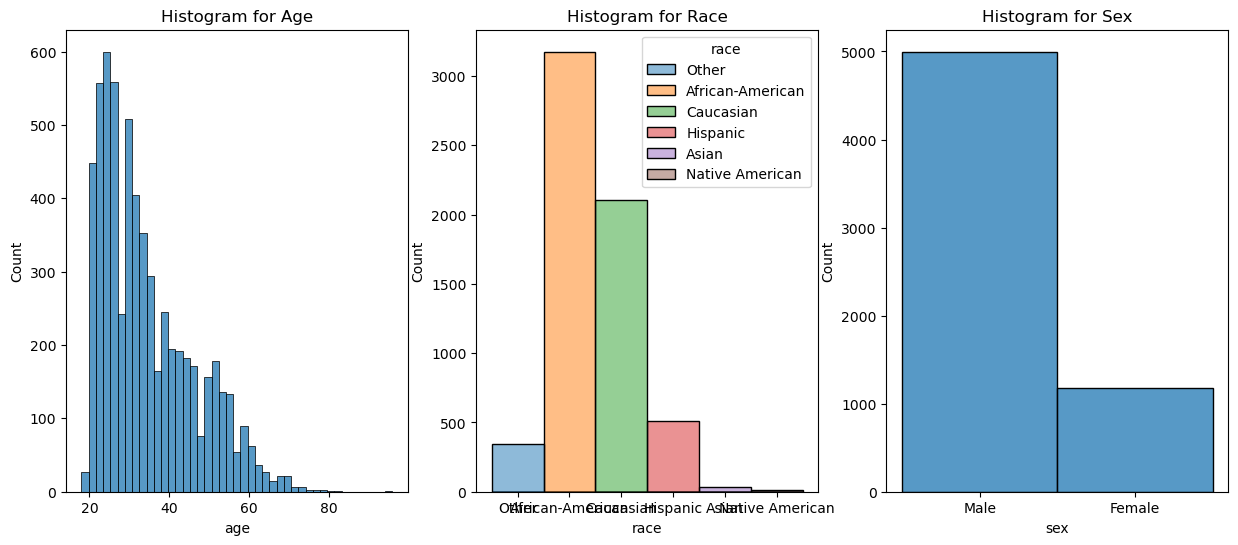

In [10]:
# write code to plot the distribution of age, race, and sex in 
# the df_analysis data
# NOTE: This is the same code I used above

fig, axs = plt.subplots(1,3, figsize=(15,6))
sns.histplot(data=df_analysis, x='age', ax=axs[0])
axs[0].set_title('Histogram for Age')

sns.histplot(data=df_analysis, x='race', hue='race', ax=axs[1])
axs[1].set_title('Histogram for Race')

sns.histplot(data=df_analysis, x='sex', ax=axs[2])
axs[2].set_title('Histogram for Sex')
plt.show()

~~**TODO:** Report changes from Step 1.2 above.~~

Not much has changed regarding the shape and the distribution of the data. They are almost identical between the two, save for the lesser number of datapoints which can be noted from the change in the numbers on the Y-Axis for each bar on each plot. In the `race` plot - the bars for "Asian" and "Native American" have been switched around, but on further inspection, they appear to be the same as the previous result. 

Observe that we are iterating through the data analysis: import, inspect & profile, preprocess, and profile again. Generate a crosstab summarizing the number of observations by race and sex:

In [11]:
# write code to generate a crosstab summarizing the number of observations by
# race and sex (i.e. a pivot table) in this code cell

ct = pd.crosstab(df_analysis['race'], df_analysis['sex'], margins=True, margins_name='Total')
print(ct)

sex               Female  Male  Total
race                                 
African-American     549  2626   3175
Asian                  2    29     31
Caucasian            482  1621   2103
Hispanic              82   427    509
Native American        2     9     11
Other                 58   285    343
Total               1175  4997   6172


~~**TODO:** Report your observations here.~~

A large chunk of the datapoints in this set of data consists of African-Americans, followed by Caucasians. Of this set, it appears that there are more males than females within these groups. In fact, in general - there are more male than female datapoints in this dataset (~19% female of 6172). The African-American group makes up about 51.4% of the dataset, while the Caucasians make up an additional 34% of the dataset. The histograms also represent this skew in race and sex, but also for the age variable - where a significant portion of the dataset is of a younger age (<40). 

### 1.5. Exploratory Analysis

Let's turn our focus to the primary variable of interest: the COMPAS recidivism score. In this exploratory analysis, we are interested in the variable named "decile_score", which is the output of the COMPAS tool.

The ProPublica analysis notes: "Judges are often presented with two sets of scores from the COMPAS system: one that classifies people into high, medium or low risk, and a corresponding decile score."

Let's plot the distribution of decile score for males and for females. 

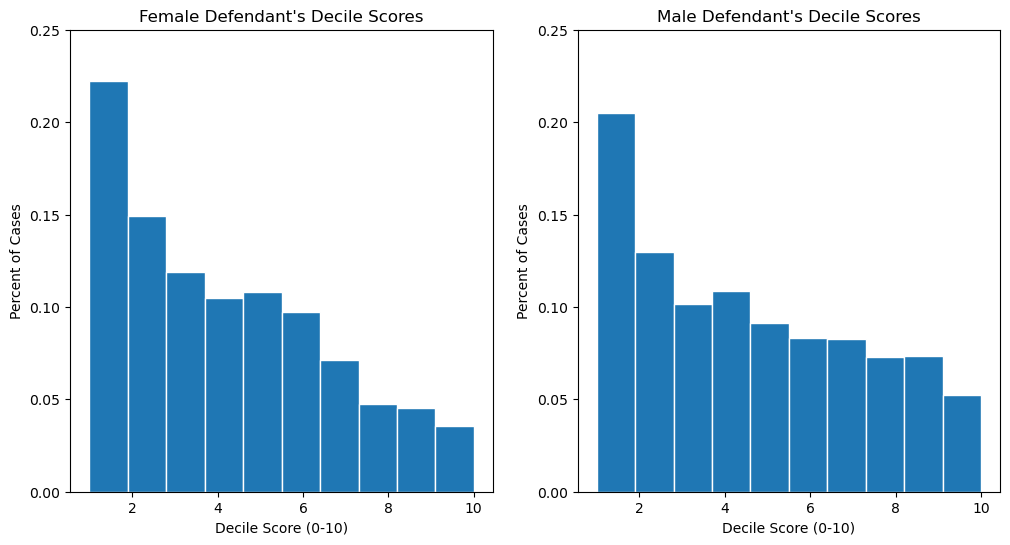

In [12]:
# plot score decile by sex
df_female = df_analysis[(df_analysis.sex == "Female")].copy()
df_male   = df_analysis[(df_analysis.sex == "Male")].copy()

fig = plt.figure(figsize = (12, 6))
fig.add_subplot(121)

plt.hist(df_female["decile_score"], ec = "white",
         weights = np.ones(len(df_female["decile_score"])) /
         len(df_female["decile_score"]))
plt.xlabel("Decile Score (0-10)")
plt.ylabel("Percent of Cases")
plt.title("Female Defendant's Decile Scores")
plt.ylim([0, 0.25])

fig.add_subplot(122)
plt.hist(df_male["decile_score"], ec = "white",
         weights = np.ones(len(df_male["decile_score"])) /
         len(df_male["decile_score"]))
plt.xlabel("Decile Score (0-10)")
plt.ylabel("Percent of Cases")
plt.title("Male Defendant's Decile Scores")
plt.ylim([0, 0.25])

plt.show()

~~**TODO:** To what extent do these distributions differ?~~

The distributions are similar in their shape, both have a right skew. It appears that greater than 20% of the datapoints have a low decile score (~22.5% and 21% for females and males respectively). While at a glance, the male decile scores appear to be greater in the female population in the left tail of the distribution - take note that the female population is significantly lower than the male population in this dataset. Though, it is worth noting that the decile scores in the male population start to increase in the right tail of the distribution (between 7 and 10), which indicates higher risk of reoffending in males. 

~~**TODO:** What about race? Repeat the above plots for Black defendants and White defendants:~~

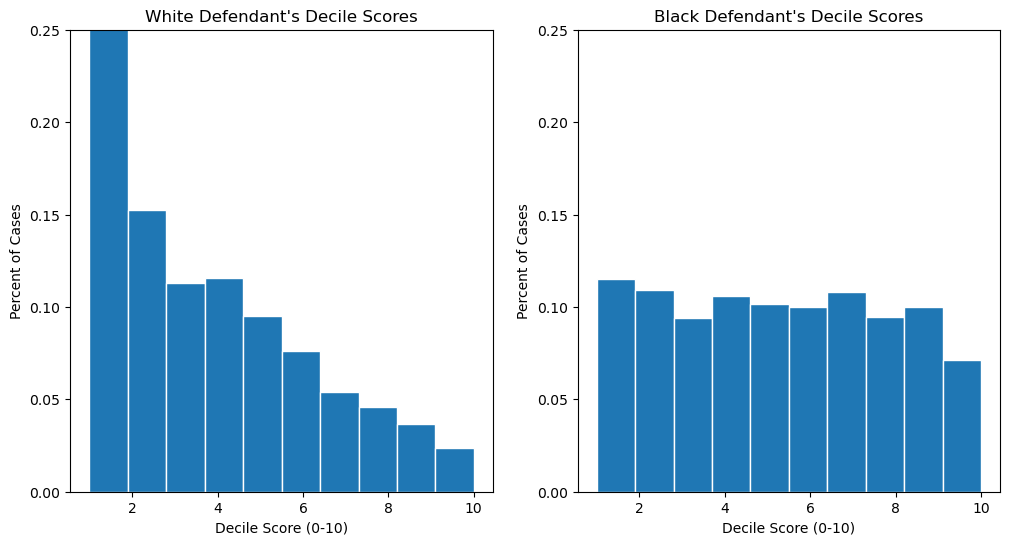

In [13]:
# write code to plot "decile_score" for White and Black defendants
# in this code cell
df_white = df_analysis.query("race == 'Caucasian'")
df_black = df_analysis.query("race == 'African-American'")

fig = plt.figure(figsize = (12, 6))
fig.add_subplot(121)

plt.hist(df_white["decile_score"], ec = "white",
         weights = np.ones(len(df_white["decile_score"])) /
         len(df_white["decile_score"]))
plt.xlabel("Decile Score (0-10)")
plt.ylabel("Percent of Cases")
plt.title("White Defendant's Decile Scores")
plt.ylim([0, 0.25])

fig.add_subplot(122)
plt.hist(df_black["decile_score"], ec = "white",
         weights = np.ones(len(df_black["decile_score"])) /
         len(df_black["decile_score"]))
plt.xlabel("Decile Score (0-10)")
plt.ylabel("Percent of Cases")
plt.title("Black Defendant's Decile Scores")
plt.ylim([0, 0.25])

plt.show()

~~**TODO:** Summarize the difference between the distribution of decile scores for Black defendants and White defendants in this text cell:~~

The shape and distribution of both these groups are vastly different from each other. The White group has a heavy right skew, while the Black group does not have a noticeable skew. A large number of datapoints in the White group appear to have a low decile scores, which decreases the further right we go through the distribution. On the contrary - the decile scores for the black groups appear to be more or less evenly distributed throughout the distribution. This is indicative of the fact that White defendents are more likely to be assigned lower decile scores than a Black defendant. 

~~**TODO:** Plot the distribution of COMPAS-assigned "risk labels" (the variable is named "score_text") for Black defendants and White defendants:~~

d:\Anaconda\envs\MDL2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\envs\MDL2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


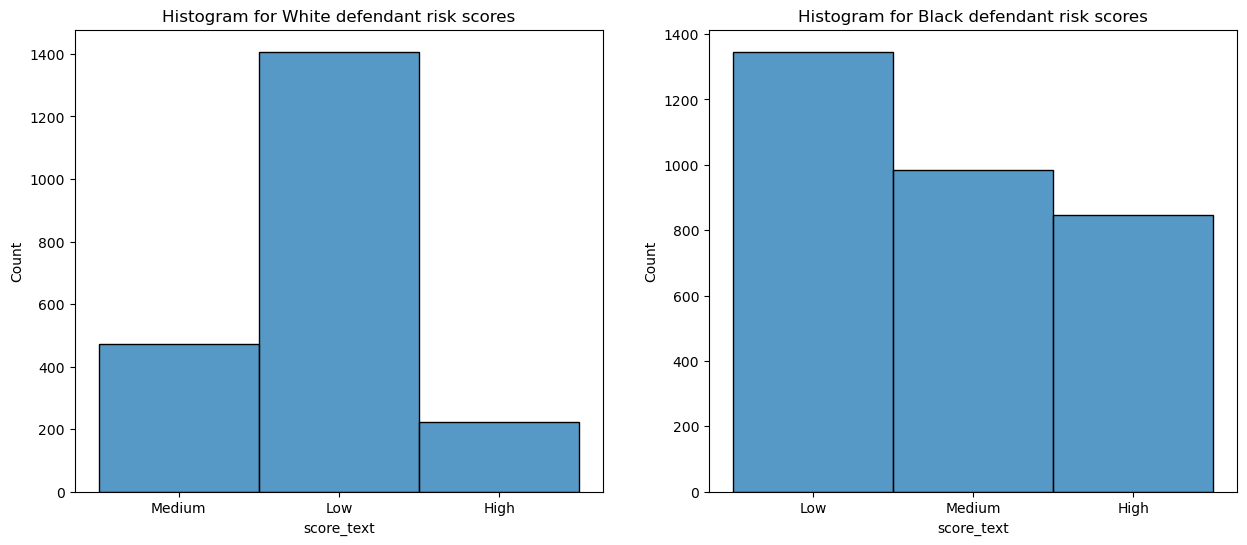

In [14]:
# plot the distribution of "score_text" for White defendants and 
# Black defendants in this code cell
fig, axs = plt.subplots(1,2, figsize=(15,6))
sns.histplot(data=df_white, x='score_text', ax=axs[0])
axs[0].set_title('Histogram for White defendant risk scores')

sns.histplot(data=df_black, x='score_text', ax=axs[1])
axs[1].set_title('Histogram for Black defendant risk scores')

plt.show()

### 1.5. Bias in COMPAS scores

ProPublica focused on racial bias in the COMPAS algorithm. In general terms, ProPublica analyzed (i) how the *risk scores* vary by race and (ii) the extent to which the *risk labels* assigned to defendants matches up with their observed recidivism and how this varies by race. We will (approximately) reproduce this analysis below.

#### 1.5.1. Preprocess Data for Logistic Regression Model

ProPublica used a logistic regression model to analyze variation in the risk scores by race. We will prepare the data by one-hot encoding the categorical variables.

In [15]:
# print(df_analysis.dtypes)

In [16]:
for i, col_type in enumerate(df_analysis.dtypes):
    if col_type == "object":
        print("\nVariable {} takes the values: {}".format(
            df_analysis.columns[i],
            df_analysis[df_analysis.columns[i]].unique()))


Variable c_charge_degree takes the values: ['F' 'M']

Variable race takes the values: ['Other' 'African-American' 'Caucasian' 'Hispanic' 'Asian'
 'Native American']

Variable age_cat takes the values: ['Greater than 45' '25 - 45' 'Less than 25']

Variable score_text takes the values: ['Low' 'Medium' 'High']

Variable sex takes the values: ['Male' 'Female']


In [17]:
df_logistic = df_analysis.copy()

# one-hot encoding
df_logistic = pd.get_dummies(df_logistic,
                             columns = ["c_charge_degree", "race",
                                        "age_cat", "sex"])

# mutate score_text to binary variable where low = {low}
# and high = {medium, high}
df_logistic["score_binary"] = np.where(df_logistic["score_text"] != "Low",
                                       "High", "Low")
df_logistic["score_binary"] = df_logistic["score_binary"].astype('category')

# rename the columns to be more instructive and consistent with statsmodel
# requirements for variable names
df_logistic.columns = df_logistic.columns.str.replace(' ', '_')
df_logistic.columns = df_logistic.columns.str.replace('-', '_')

renamed_cols = {'age_cat_25___45':'age_cat_25_to_45',
                'c_charge_degree_F':'Felony',
                'c_charge_degree_M':'Misdemeanor'}

df_logistic = df_logistic.rename(columns = renamed_cols)

# NOTE: Interesting - I did not know statsmodels needed a specific format for a variable name.

Check that recoding resulted in the desired data structure:

In [18]:
df_logistic.head()

,id,age,score_text,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,Felony,Misdemeanor,...,race_Caucasian,race_Hispanic,race_Native_American,race_Other,age_cat_25_to_45,age_cat_Greater_than_45,age_cat_Less_than_25,sex_Female,sex_Male,score_binary
0,1,69,Low,0,-1.0,1,0,0,True,False,...,False,False,False,True,False,True,False,False,True,Low
1,3,34,Low,0,-1.0,3,1,1,True,False,...,False,False,False,False,True,False,False,False,True,Low
2,4,24,Low,4,-1.0,4,1,1,True,False,...,False,False,False,False,False,False,True,False,True,Low
5,7,44,Low,0,0.0,1,0,0,False,True,...,False,False,False,True,True,False,False,False,True,Low
6,8,41,Medium,14,-1.0,6,1,1,True,False,...,True,False,False,False,True,False,False,False,True,High


#### 1.5.2. Estimate Logistic Regression Model

Following ProPublica, we specify the following logistic regression model:

In [19]:
# Right-hand side
explanatory = "priors_count + two_year_recid + Misdemeanor + \
age_cat_Greater_than_45 + age_cat_Less_than_25 + \
race_African_American + race_Asian + race_Hispanic + race_Native_American + \
race_Other + sex_Female"

# Left-hand side
response = "score_binary"

# Formula
formula = response + " ~ " + explanatory
print(formula)

score_binary ~ priors_count + two_year_recid + Misdemeanor + age_cat_Greater_than_45 + age_cat_Less_than_25 + race_African_American + race_Asian + race_Hispanic + race_Native_American + race_Other + sex_Female


Let's fit the model:

In [20]:
# Note: using family = sm.families.Binomial() specifies a logistic regression
model = sm.formula.glm(formula = formula, 
                       family = sm.families.Binomial(),
                       data = df_logistic).fit()

print(model.summary())

                              Generalized Linear Model Regression Results                              
Dep. Variable:     ['score_binary[High]', 'score_binary[Low]']   No. Observations:                 6172
Model:                                                     GLM   Df Residuals:                     6160
Model Family:                                         Binomial   Df Model:                           11
Link Function:                                           Logit   Scale:                          1.0000
Method:                                                   IRLS   Log-Likelihood:                -3084.2
Date:                                         Thu, 18 Sep 2025   Deviance:                       6168.4
Time:                                                 00:25:11   Pearson chi2:                 6.07e+03
No. Iterations:                                              6   Pseudo R-squ. (CS):             0.3128
Covariance Type:                                     nonrobust  

In [21]:
# Let's see when the dependent variable has been converted from nominal into two dummy variables: 
print(sm.formula.glm(formula = formula, 
                       family = sm.families.Binomial(),
                       data = df_logistic).endog_names)

# Predict the probability of the score being High (from the way the nominal values are listed above)
y_pred = model.predict(df_logistic)

['score_binary[High]', 'score_binary[Low]']


#### 1.5.3. Interpret Estimates

Take a moment to read through the model summary. 

One way to interpret the estimates is by calculating odds ratios. To calculate odds ratios, we take the exponential of the coefficients. For example, taking the exponential of the coefficient for sex_Female ($\beta_{female}$ = 0.2213) will return the odds of score_text taking the value "high" for a female relative to a male. Calculate this odds ratio here:



In [22]:
# write code to calculate the odds for female defendants here
# NOTE: So basically we need to take the coefficient of the sex_Female[T.True] variable and take the exponent of that. 
female_exp = np.exp(model.params.iloc[9])
print("The odds of risk of a Female being assigned as High risk relative a Male is:", round(female_exp, 2))

The odds of risk of a Female being assigned as High risk relative a Male is: 1.25


In words, the odds that COMPAS labeled a defendant as "high risk" of recidivism is 1.25 times greater for a female than a male.

Next, calculate the odds ratio for all of the coefficients in the model:

In [23]:
# write code to calculate the odds ratio for all variables in the 
# logistic regression model here
odds = np.exp(model.params)
print(odds)

Intercept                          0.217504
Misdemeanor[T.True]                0.732537
age_cat_Greater_than_45[T.True]    0.257784
age_cat_Less_than_25[T.True]       3.700213
race_African_American[T.True]      1.611567
race_Asian[T.True]                 0.775370
race_Hispanic[T.True]              0.651554
race_Native_American[T.True]       4.031779
race_Other[T.True]                 0.437645
sex_Female[T.True]                 1.247656
priors_count                       1.308584
two_year_recid                     1.985484
dtype: float64


Take a moment to read through these coefficients. What is the reference category for each variable? (e.g. For females, the reference category is male.) Think in terms of comparisons, for example:

> A person with a value of [ &nbsp; &nbsp; ] on variable [ &nbsp; &nbsp; ] is [ &nbsp; &nbsp; ] times more likely to be labeled high risk compared to a person with a value of [ &nbsp; &nbsp; ] on variable [ &nbsp; &nbsp; ]

In the female example above, this could be stated:

> "A person with a value of female on variable sex is 1.25 times more likely to be labeled high risk compared to a person with a value of male on variable sex"

Of course, we should be more straightforward when writing up results. "A person with a value of male on variable sex" is rather verbose; "males" will suffice. Interpreting model estimates in straightforward terms is an underrated skill.


~~**TODO:** Summarize the odds associated with the "age_cat" variable in this text cell (two sentences maximum):~~

- For `age_cat_Greater_than_45[T.True]`, a person with an age greater than 45 is 0.26 times more likely to be labelled high risk than a person who is less than 25. 
- Similarly, for `age_cat_Less_than_25[T.True]`, a person with an age less than 25 is 3.7 times more likely to be labelled high risk than a person who is greater than 45. 

~~**TODO:** Before moving on, think about how the above estimates relate to the concepts of fairness introduced in the lectures. Write down your answer as to what extent do these findings about the assignment of risk labels in COMPAS relate to pre-existing bias, technical bias, and emergent bias.~~

The first thing that draws my attention up to this point in the notebook was how the risk labels appear to be "arbitrarily" assigned to each datapoint. More specifically, how datapoints initially labelled "Medium" and "High" were grouped into one "High" category. While I cannot critique "why" such a solution was used, we do know that this method has the potential to create an element of unfairness by adding to the pre-existing bias associated with the dataset - since the data itself is known to create an unfair or biased outcome for African American Males in particular. I postulate that similar scenarios to this case study would also exacerbate technical biases that stem from algorithmic limitations - which when stacked with a bad dataset, would create a problem that will affect many people directly and indirectly when implemented.

For example, I could also see how this algorithm could influence external judicial systems and policing practices when and if the people involved in making decisions take the model's "word as gospel" without understanding its limitations, which then adds an emergent bias into the mix. If these aren't caught earlier on - this has the potential to create a feedback loop between the model and the external systems; which will impact other users and tasks downstream. 

#### 1.5.4. Predictive Accuracy


ProPublica reported the false positive rate and false negative rate for black defendants and white defendants, separately (using a somewhat different dataset). We will use the ```df_logistic``` data we preprocessed above. (Note therefore that the numbers we calculate below will not match those reported by ProPublica). 

For ease, we will generate a crosstab of the variable denoting recidivism within two years (```is_recid```) and the binary score variable (```score_binary```): (note that we can similarly generate a crosstab of ```y_pred``` and ```score_binary``` to evaluate the trained model)

In [24]:
print("All defendants")
pd.crosstab(df_logistic["score_binary"], df_logistic["is_recid"])

All defendants


is_recid,0,1
score_binary,,
High,934,1817
Low,2248,1173


~~**TODO:** Based on this crosstab, calculate the false positive rate and false negative rate for all defendants.~~

In [25]:
# write code to calculate the false positive rate and false negative rate for all defendants
# in this code cell
# FPR = FP / (FP+TN) and FNR = FN / (FN+TP)
fpr, fnr = 934 / (934 + 2248), 1173 / (1173 + 1817)
print('False Positive rate:', round(fpr, 3) * 100)
print('False Negative rate:', round(fnr,3) * 100)

False Positive rate: 29.4
False Negative rate: 39.2


~~**TODO:** How do the false positive and false negative rates vary by sex? Let's generate a crosstab of "score_binary" and "is_recid" for female defendants:~~

In [26]:
# write code to generate a similar crosstab for female defendants
# in this code cell
# rewriting over the existing female dataframe using the logistic dataframe rather than the original
df_female = df_logistic.query("sex_Female == True")
pd.crosstab(df_female['score_binary'], df_female['is_recid'])

is_recid,0,1
score_binary,,
High,220,256
Low,520,179


~~**TODO:** Based on this crosstab, calculate the false positive and false negative rates for females:~~

In [27]:
# write code to calculate the false positive rate and false negative rate for
# female defendants in this code cell
fpr, fnr = 220 / (220 + 520), 179 / (179 + 256)
print('False Positive rate:', round(fpr, 3) * 100)
print('False Negative rate:', round(fnr,3) * 100)

False Positive rate: 29.7
False Negative rate: 41.099999999999994


~~**TODO:** Now repeat the process and calculate the false positive rate and false negative rate for male defendants:~~

In [28]:
# write code to generate a crosstab for male defendants 
# and calculate the false positive rate and false negative rate for
# male defendants in this code cell
df_male = df_logistic.query("sex_Male == True")
pd.crosstab(df_male['score_binary'], df_male['is_recid'])

is_recid,0,1
score_binary,,
High,714,1561
Low,1728,994


In [29]:
fpr, fnr = 714 / (714 + 1728), 994 / (994 + 1561)
print('False Positive rate:', round(fpr, 3) * 100)
print('False Negative rate:', round(fnr,3) * 100)

False Positive rate: 29.2
False Negative rate: 38.9


~~**TODO:** How do the false positive and false negative rates vary by race? Calculate the false positive rate and false negative rate for White defendants:~~

In [30]:
# write code to generate a crosstab for White defendants 
# and calculate the false positive rate and false negative rate for
# White defendants in this code cell
df_white = df_logistic.query("race_Caucasian == True")
pd.crosstab(df_white['score_binary'], df_white['is_recid'])

is_recid,0,1
score_binary,,
High,266,430
Low,963,444


In [31]:
fpr, fnr = 266 / (266 + 963), 444 / (444 + 430)
print('False Positive rate:', round(fpr, 3) * 100)
print('False Negative rate:', round(fnr, 3) * 100)

False Positive rate: 21.6
False Negative rate: 50.8


~~**TODO:** Lastly, calculate the false positive rate and false negative rate for Black defendants:~~

In [32]:
# write code to generate a crosstab for Black defendants 
# and calculate the false positive rate and false negative rate for
# Black defendants in this code cell
df_black = df_logistic.query("race_African_American == True")
pd.crosstab(df_black['score_binary'], df_black['is_recid'])

is_recid,0,1
score_binary,,
High,581,1248
Low,821,525


In [33]:
fpr, fnr = 581 / (581 + 821), 525 / (525 + 1248)
print('False Positive rate:', round(fpr, 3) * 100)
print('False Negative rate:', round(fnr, 3) * 100)

False Positive rate: 41.4
False Negative rate: 29.599999999999998


~~**TODO:** Review and compare the false positive rates and false negative rates above. Consider how these rates relate to the concepts of fairness you have encountered in the lectures.~~

Observations and Synthesis is given below: 
- All: It appears that there is a 29% chance to be misclassified as high risk when they do not recidivate; likewise 39% chance to be mislabelled as low risk when a person does recidivate.
- Females: Show rates of 29.7% and 41.1% respectively, with a similar interpretation as above. Females appear to have a high false negative rate, impying that females are more likely of being misclassified as low risk when they do recidivate.
- Males: Show rates of 29.2% and 38.9% respectively. Comparing them to females, they have similar FPRs but like we stated above, females have a higher FNR compared to this group. 
- White: Shows rates of 21.6% and 50.8% respectively. Note the high FNR, implying that white defendants are more likely to be labelled as low risk. 
- Black: Shows rates of 41.4% and 29.5% respectively. The inverse is true when comparing this group to white defendants. Black defendants are more likely to be labelled high risk.

The difference the the FNR between males and females, as well as the difference in false positives and false negatives amongst the Black and White groups seems indicative of a disparate impact on groups in terms of fairness, while the gender groups (Females and Males) appear to have a slight indication of bias towards female defendants in the sense that their FNR implies of some form of leniency, or a greater chance of receiving a reduced sentence which constitutes a Equality of Outcome issue amongst the gender groups.

What is interesting here is that these rates can serve as indications of underlying bias outside the model itself - perhaps in terms of policing policies (which may be true if we consider how often racial profiling can be applied across different departments), or in how the judicial system perceives a select group of individuals. 

## Part 2: Exploring fairness during model training

We discussed a number of fairness metrics in the context of binary classification. In this part of the assignment, we will explore aspects of fairness in model predictions while training our model.

This notebook has four stages in which we will: 
1. Compute the base rates on the original data
2. Measure bias of the model trained earlier using fairness metrics (including statistical parity and equalized odds). 
4. Train a classifier to predict recidivism using the data without sensitive features, and measure bias of the updated classifier using several fairness metrics. 
5. (Extra credit) Use IBM's AIF360 toolkit to compute the fairness metrics.

### Sensitive attributes

In the class, we learnt about sensitive attributes for computing model fairness. In this assignment, we will compute different fairness metrics in the following three scenarios:

<ol>
    <li> considering only "age" as the sensitive attribute </li>
    <li> considering only "sex" as the sensitive attribute </li>
    <li> considering only "race" as the sensitive attribute </li>
</ol>

### 2.2. Compute base rates on original data
Before we consider model fairness, let us first compare the base rates for the privileged and unprivileged groups with that of the entire data. Base rate indicates the fraction of data (or a subset of the data) that has positive outcomes. Base rates indicate class imbalance in the dataset.

In the following code block, compute the base rates for the entire dataset, and for the privileged and unprivileged groups. In our dataset, we need to consider the `is_recid` attribute for computing base rate. 

In [34]:
# Write code to compute base rates with respect to "age" as the sensitive attribute
# Note that you may have to discretize age into two categories -- old and young -- choose a threshold
# based on our discussion in class or from your observation on different thresholds
# base data is df_compas, which is what we will be using - with no preprocessing, for age - we'll do the same thing we did in the preprocessing cells to convert ages
# NOTE: I would have gone with young, middle-aged, and old but instructions state that we have to discretize into two categories
df_compas['age_transformed'] = np.where(df_compas.age < 45, "young", "old")
#df_compas['age_transformed']

# I'm taking into account that values with -1 in is_recid might may not be viable to measure outcomes, so only 0 and 1 are being considered.
df_cut = df_compas.query("is_recid == 0 or is_recid == 1") #turns out the number of uniques is 0 and 1, but I'll keep this in just in case

# positive and negative outcome filtering
#recid_pos = df_cut.query("is_recid == 1")
#recid_neg = df_cut.query("is_recid == 0")
# We need to use either the mean or value counts norm function to get a complete picture

# Get base rates by age given recid = 1 or 0, should display both
age_br = df_cut.groupby('age_transformed')['is_recid'].value_counts(normalize=True).unstack()
print(age_br)

is_recid                0         1
age_transformed                    
old              0.658629  0.341371
young            0.479780  0.520220


In [35]:
# Write code to compute base rates with respect to "sex" as the sensitive attribute
sex_br = df_cut.groupby('sex')['is_recid'].value_counts(normalize=True).unstack()
print(sex_br)

is_recid         0         1
sex                         
Female    0.620072  0.379928
Male      0.494587  0.505413


In [36]:
# Write code to compute base rates with respect to "race" as the sensitive attribute
race_br = df_cut.groupby('race')['is_recid'].value_counts(normalize=True).unstack()
print(race_br)

is_recid                 0         1
race                                
African-American  0.449134  0.550866
Asian             0.656250  0.343750
Caucasian         0.582315  0.417685
Hispanic          0.615385  0.384615
Native American   0.388889  0.611111
Other             0.620690  0.379310


### 2.3. Evaluate model fairness 
In this part of the assignment, you will write functions to compute statistical parity and equalized odds. Recall that both of these metrics use the model predictions $\hat{Y}$ (computed as $y\_pred$ above).

Let $S=0$ indicate the unprivileged group and $S=1$ indicate the privileged group. FPR and FNR represent the false positive rate and false negative rate respectively. Then, we can compute:

**Statistical parity** = $P(\hat{Y} = 1 | S = 0) - P(\hat{Y} = 1 | S = 1)$ 

**Equalized odds** $\dfrac{(FPR_{S=0} - FPR_{S=1}) + (FNR_{S=0} - FNR_{S=1})}{2}$

where $FPR = P(\hat{Y}=1 | Y=0)$ and $FNR = P(\hat{Y}=0 | Y=1)$


In [37]:
df_sensitive = df_logistic[['is_recid', 'race_African_American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native_American', 'race_Other',
                            'age_cat_25_to_45', 'age_cat_Greater_than_45', 'age_cat_Less_than_25', 'sex_Female', 'sex_Male', 'score_binary']]
df_sensitive['y_pred'] = y_pred
df_sensitive

C:\Users\ldmag\AppData\Local\Temp\ipykernel_76548\526021239.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensitive['y_pred'] = y_pred


,is_recid,race_African_American,race_Asian,race_Caucasian,race_Hispanic,race_Native_American,race_Other,age_cat_25_to_45,age_cat_Greater_than_45,age_cat_Less_than_25,sex_Female,sex_Male,score_binary,y_pred
0,0,False,False,False,False,False,True,False,True,False,False,True,Low,0.023951
1,1,True,False,False,False,False,False,True,False,False,False,True,Low,0.410362
2,1,True,False,False,False,False,False,False,False,True,False,True,Low,0.883057
5,0,False,False,False,False,False,True,True,False,False,False,True,Low,0.065185
6,1,False,False,True,False,False,False,True,False,False,False,True,High,0.949096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,0,True,False,False,False,False,False,False,False,True,False,True,High,0.564651
7210,0,True,False,False,False,False,False,False,False,True,False,True,Low,0.564651
7211,0,False,False,False,False,False,True,False,True,False,False,True,Low,0.023951
7212,0,True,False,False,False,False,False,True,False,False,True,False,Low,0.417883


In [ ]:
up_race = 

In [59]:
# Write function to compute statistical parity over model predictions with a given sensitive attribute
# y_pred was created using the df_logistic variable, so I'll be using that instead.
def compute_SP(df, priv_group, underpriv_group, SVar_name):
    '''
        df: dataframe variable
        priv_group: Column name for perceived privileged group, must be a string of the dataframe column being passed
        underpriv_group: Column name for perceived unprivileged group, must be a string of the dataframe column being passed
        SVar_name: Must be string of either 'race', 'sex', or 'age'
    '''
    if SVar_name == 'race':
        up_race = df[df[underpriv_group]==True]
        p_race = df[df[priv_group]==True]
        prob_up = (up_race['score_binary']=='High').mean()
        prob_p = (p_race['score_binary']=='High').mean()
        sp = prob_up - prob_p
    elif SVar_name == 'age':
        up_age = df[df[underpriv_group]==True]
        p_age = df[df[priv_group]==True]
        prob_up = (up_age['score_binary']=='High').mean()
        prob_p = (p_age['score_binary']=='High').mean()
        sp = prob_up - prob_p
    elif SVar_name == 'sex':
        up_sex = df[df[underpriv_group]==True]
        p_sex = df[df[priv_group]==True]
        prob_up = (up_sex['score_binary']=='High').mean()
        prob_p = (p_sex['score_binary']=='High').mean()
        sp = prob_up - prob_p
    else:
        print('Function encountered an error, please check if SVar, Group, and Dataframe arguments are correct.')
    return sp

# Write function to compute equalized odds with a given sensitive attribute
def get_rates(df, y_actual):
    tn = df[df[y_actual] == 0] # the previous method we used to get these values are not viable here
    tp = df[df[y_actual] == 1]
    fp = tn[tn['score_binary']=='High']
    fpr = len(fp) / len(tn)
    fn = tp[tp['score_binary']=='Low']
    fnr = len(fn) / len(tp)
    return fpr, fnr

def compute_EO(df, y_actual, priv_group, underpriv_group, SVar_name):
    if SVar_name == 'race':
        up_race = df[df[underpriv_group]==True]
        p_race = df[df[priv_group]==True]
        fpr_unpriv, fnr_unpriv = get_rates(up_race, y_actual)
        fpr_priv, fnr_priv = get_rates(p_race, y_actual)
        eo = ((fpr_unpriv - fpr_priv) + (fnr_unpriv - fnr_priv)) / 2
    elif SVar_name == 'age':
        up_age = df[df[underpriv_group]==True]
        p_age = df[df[priv_group]==True]
        fpr_unpriv, fnr_unpriv = get_rates(up_age, y_actual)
        fpr_priv, fnr_priv = get_rates(p_age, y_actual)
        eo = ((fpr_unpriv - fpr_priv) + (fnr_unpriv - fnr_priv)) / 2
    elif SVar_name == 'sex':
        up_sex = df[df[underpriv_group]==True]
        p_sex = df[df[priv_group]==True]
        fpr_unpriv, fnr_unpriv = get_rates(up_sex, y_actual)
        fpr_priv, fnr_priv = get_rates(p_sex, y_actual)
        eo = ((fpr_unpriv - fpr_priv) + (fnr_unpriv - fnr_priv)) / 2
    else:
        print('Function encountered an error, please check if SVar, Group, and Dataframe arguments are correct.')
    return eo


In [61]:
# Report statistical parity and equalized odds using "race" as the sensitive attribute
sp_race = compute_SP(df=df_logistic, priv_group='race_Caucasian', underpriv_group='race_African_American', SVar_name='race')
eo_race = compute_EO(df=df_logistic, y_actual='is_recid', priv_group='race_Caucasian', underpriv_group='race_African_American', SVar_name='race')
print('Parity is:', sp_race) 
print('EO is:', eo_race)

# Report statistical parity and equalized odds using "sex" as the sensitive attribute
sp_sex = compute_SP(df=df_logistic, priv_group='sex_Male', underpriv_group='sex_Female', SVar_name='sex')
eo_sex = compute_EO(df=df_logistic, y_actual='is_recid', priv_group='sex_Male', underpriv_group='sex_Female', SVar_name='sex')
print('Parity is:', sp_sex) 
print('EO is:', eo_sex)

# Report statistical parity and equalized odds using "age" as the sensitive attribute
sp_age = compute_SP(df=df_logistic, priv_group='age_cat_Greater_than_45', underpriv_group='age_cat_Less_than_25', SVar_name='age')
eo_age = compute_EO(df=df_logistic, y_actual='is_recid', priv_group='age_cat_Greater_than_45', underpriv_group='age_cat_Less_than_25', SVar_name='age')
print('Parity is:', sp_age) 
print('EO is:', eo_age)

Parity is: 0.2451072146652139
EO is: -0.00696450031533126
Parity is: -0.05016678091961557
EO is: 0.013683580948578605
Parity is: 0.4224925373391415
EO is: 0.04576584556898006


**TODO:** What can you say about the model being more or less biased than the data (with respect to base rates on the data)?

### 2.4. Model training without using the sensitive feature

We discussed in the class how removing a sensitive attribute is not enough to generate models that result in fair predictions. In this step, we will see if that is indeed true in action.

#### 2.4.1. In the following, we will build models trained without the sensitive attribute (once each for the "sex", "age" and "race" attributes). 

In [ ]:
# Right-hand side (does not include sex)
explanatory = "priors_count + two_year_recid + Misdemeanor + \
age_cat_Greater_than_45 + age_cat_Less_than_25 + \
race_African_American + race_Asian + race_Hispanic + race_Native_American + \
race_Other"

# Left-hand side
response = "score_binary"

# Formula
formula = response + " ~ " + explanatory
print(formula)

model_no_sex = sm.formula.glm(formula = formula, 
                       family = sm.families.Binomial(),
                       data = df_logistic).fit()

# Calculate the prediction probabilities on the updated model
y_pred_no_sex = model_no_sex.predict()

# Similarly, retrieve predictions for the models learnt without age and race

#### 2.4.2. Evaluating updated model

Now, let's evaluate the predictions obtained from the updated model using the functions that your wrote in Step 2.1. Although the sensitive attribute has not been used in training the model, the group memberships will be used to compute the fairness metrics.

In [ ]:
# Report statistical parity and equalized odds using "race" as the sensitive attribute

# Report statistical parity and equalized odds using "sex" as the sensitive attribute

# Report statistical parity and equalized odds using "age" as the sensitive attribute

**TODO:** Compare the metrics obtained here with those obtained in Step 2.1. What can you say about whether or not using the sensitive attribute has an effect on bias in model predictions for this example?

### 2.5. (**Extra Credit**) Step 5: Using AIF360 to compute fairness metrics

In this step, we will use the "aif360" package to detect bias in the dataset (AIF360 is IBM's AI Fairness toolkit) to evaluate fairness of the learned model. This package requires the data to be in a certain format, which will be clear as we walk through the following.

In [ ]:
# You should need to run this package installation only once. After the first time, you can comment it out
# !pip install aif360==0.2.2

In [66]:
from aif360.datasets import StandardDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
# from aif360.algorithms.postprocessing import EqOddsPostprocessing

from aif360.explainers import MetricTextExplainer, MetricJSONExplainer

Let us use "sex" as the sensitive attribute and defined privileged and unprivileged values. We use the CompasDataset in aif360 to do our analysis.

In [67]:
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas

In [68]:
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
dataset_orig = load_preproc_data_compas(['sex'])

We will convert the dataset to a Pandas dataframe, extract the input features (X) and target variable (y).

In [69]:
dataset_orig_df = dataset_orig.convert_to_dataframe()[0]
x_train = dataset_orig_df.drop("two_year_recid", axis=1)
y_train = dataset_orig_df.two_year_recid

First, we will use our model to calculate predicted values for the data and attach them as a new column in the data frame. 

In [70]:
# Copy the dataset
preds_df = dataset_orig_df.copy()

model = LogisticRegression(C=0.5, penalty="l1", solver='liblinear')
model.fit(x_train, y_train)

# Calculate predicted values
preds_df['two_year_recid'] = model.predict(x_train)

Then we will create an object of the aif360 StandardDataset class. You can read more about this in the documentation:
https://aif360.readthedocs.io/en/latest/modules/standard_datasets.html#aif360.datasets.StandardDataset

In [71]:
orig_aif360 = StandardDataset(dataset_orig_df, label_name='two_year_recid', protected_attribute_names=['sex'], 
                privileged_classes=[[1]], favorable_classes=[1])

preds_aif360 = StandardDataset(preds_df, label_name='two_year_recid', protected_attribute_names=['sex'], 
                privileged_classes=[[1]], favorable_classes=[1])

Let us calculate some fairness metrics on the training data using the `ClassificationMetric` function in aif360. 

In [72]:
orig_vs_preds_metrics = ClassificationMetric(orig_aif360, preds_aif360,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)

In [73]:
# For example, we can compute statistical parity difference as below:
print("Statistical parity difference: ", orig_vs_preds_metrics.statistical_parity_difference())

Statistical parity difference:  0.2213804369696005


**TODO:** Compare the value obtained above with those obtained in steps 2.3 and 2.4.2 above. You might observe a difference in the performance due to the way the dataset has been created within aif360 and due to the difference in the way the models have been implemented.

Feel free to explore some of the other fairness metrics that we discussed in class. You can find a list of fairness metrics currently supported by aif360 here: https://aif360.readthedocs.io/en/latest/modules/generated/aif360.metrics.ClassificationMetric.html.

# Submitting this Assignment Notebook

Once complete, please submit your assignment notebook as an attachment under "Assignments > Assignment 2" on Brightspace. You can download a copy of your notebook using ```File > Download .ipynb```. Please ensure you submit the `.ipynb` file (and not a `.py` file).